#### Question 1 

It's state space contains 100 states, including 99 nonterminal states and 1 terminal state, and 19 unattainable states and 81 attainable states. Each state is represented by a small square. Since the transition matrix is very sparse, we can use the map representation as:
$$
\mathcal{N} \rightarrow (\mathcal{S} \rightarrow [0,1]).
$$
The key is a nonterminal state, and each nonterminal state maps to a probability distribution of the next state. The snakes and ladders effect the transition probability by changing the "potential next state". For example, 
$$
2 \rightarrow (\{3, {14}, 5, 6, 7, 8\} \rightarrow 1/6),
$$
instead of $2 \rightarrow (\{3, {4}, 5, 6, 7, 8\} \rightarrow 1/6)$.

#### Question 2


In [1]:
from abc import ABC, abstractmethod
import random
import statistics
import numpy as np
import itertools
from dataclasses import dataclass
from typing import Generic, TypeVar, Optional, Mapping, Callable, Iterable, Sequence
import matplotlib.pyplot as plt
from distribution import Categorical, SampledDistribution, FiniteDistribution

In [2]:
# Markov Process
from abc import ABC, abstractmethod
from __future__ import annotations

S = TypeVar("S")
X = TypeVar("X")

class State(ABC, Generic[S]):
    state: S
    
    def on_non_terminal(self, f: Callable[[NonTerminal[S]], X], default: X) -> X:
        if isinstance(self, NonTerminal):
            return f(self)
        else:
            return default

@dataclass(frozen = True)
class Terminal(State[S]):
    state: S

@dataclass(frozen = True)
class NonTerminal(State[S]):
    state: S

class MarkovProcess(ABC, Generic[S]):
    @abstractmethod
    def transition(self, state: NonTerminal[S]):
        pass
    
    def simulate(self, start_state_distribution) -> Iterable[State[S]]:
        state: State[S] = start_state_distribution.sample()
        yield state
        
        while isinstance(state, NonTerminal):
            state = self.transition(state).sample()
            yield state

In [302]:
@dataclass(frozen = True)
class GameState:
    state: int

class GameMPFinite():
    
    terminal_state: int
    non_terminal_states_list: list
    non_terminal_states: Sequence[GameState]
    
    def __init__(self, terminal_state: int):
        self.terminal_state = terminal_state
        transit = []
        for i in range (self.terminal_state):
            transit.append(i)
        transit[1] = 38; transit[4] = 14; transit[9] = 31; transit[16] = 6; transit[21] = 42; transit[28] = 84;
        transit[36] = 44; transit[47] = 26; transit[49] = 11; transit[51] = 67; transit[56] = 53; 
        transit[62] = 19; transit[64] = 60; transit[71] = 91; transit[80] = self.terminal_state;
        transit[87] = 24; transit[93] = 73; transit[95] = 75; transit[98] = 78
        self.transit = transit
        self.non_terminal_states_list = list(set(transit))
        self.non_terminal_states_list.remove(self.terminal_state)
        length = len(self.non_terminal_states_list)
        self.non_terminal_states = [GameState(self.non_terminal_states_list[i]) for i in range (length)]
    
    def transition_map(self):
        d = {}  #distribution
        for i in self.non_terminal_states_list:
            state = GameState(i)
            state_prob_map = {}
            for j in range (6):
                if i+j+1 < self.terminal_state:
                    state_prob_map[GameState(self.transit[i+j+1])] = 1/6
                else:
                    state_prob_map[GameState(self.terminal_state)] = (6-j)/6
                    break
            d[GameState(i)] = Categorical(state_prob_map)
        return d
        
    def transition(self, current_state):
        return self.transition_map()[current_state]
    
    def simulation(self):
        state = GameState(0)
        trace = []
        while state in self.non_terminal_states:
            trace.append(state)  
            outcome = list(self.transition(state).table())
            weight = list(self.transition(state).table().values())
            state = random.choices(outcome, weights=weight)[0]
        return trace
        
    def time_step_distribution(self, num_simulation):
        time_step = np.zeros(250)
        for t in range (num_simulation):
            step = len(self.simulation())
            time_step[step] += 1
        return time_step

In [303]:
gameMP = GameMPFinite(100)
time_step = gameMP.time_step_distribution(1000)

Text(0.5, 0, 'total time steps')

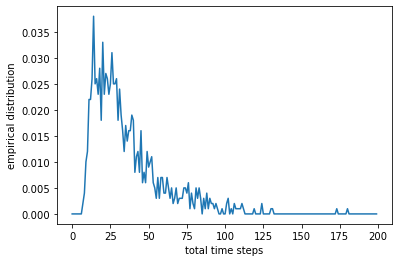

In [309]:
#probability distribution of time steps to finish the game.
plt.plot(time_step[:200]/1000)
plt.ylabel("empirical distribution")
plt.xlabel("total time steps")

#### Question 3

Suppose the minimum step size of the frog is a, and the maximum step size of the frog is b. We use $g(L)$ to denote the expected number of step the frog takes to cross a L-length river, i.e.
$$
g(L) = \mathbb{E}(N ),
$$
where $N$ is the random step number. Denote $S_1$ to be the first step size of this frog, then we should have
\begin{align*}
g(L) &= \mathbb{E}(N | S_1 = a) \cdot \mathbb{P}(S_1=a) + \mathbb{E}(N | S_1 = a+1) \cdot \mathbb{P}(S_1=a+1) + \cdots + \mathbb{E}(N | S_1 = b) \cdot \mathbb{P}(S_1=b) \\
& = \frac{1}{b-a+1}\cdot \big( g(L-a) + g(L-a-1)+\cdots+g(L-b)\big) + 1
\end{align*}
when $L\geq 1$. With boundary condition that
$$
g(L) = 0, \ \text{for}\ L \leq 0,
$$
we can easily solve $g(L)$ for any $L$ iteratively.

#### Question 4

The reward should be the number of each dice roll. 

In [322]:
@dataclass(frozen = True)
class GameState:
    state: int

class GameMPFinite():
    
    terminal_state: int
    non_terminal_states_list: list
    non_terminal_states: Sequence[GameState]
    
    def __init__(self, terminal_state: int):
        self.terminal_state = terminal_state
        transit = []
        for i in range (self.terminal_state):
            transit.append(i)
        transit[1] = 38; transit[4] = 14; transit[9] = 31; transit[16] = 6; transit[21] = 42; transit[28] = 84;
        transit[36] = 44; transit[47] = 26; transit[49] = 11; transit[51] = 67; transit[56] = 53; 
        transit[62] = 19; transit[64] = 60; transit[71] = 91; transit[80] = self.terminal_state;
        transit[87] = 24; transit[93] = 73; transit[95] = 75; transit[98] = 78
        self.transit = transit
        self.non_terminal_states_list = list(set(transit))
        self.non_terminal_states_list.remove(self.terminal_state)
        length = len(self.non_terminal_states_list)
        self.non_terminal_states = [GameState(self.non_terminal_states_list[i]) for i in range (length)]
    
    def transition_map(self):
        d = {}  #distribution
        for i in self.non_terminal_states_list:
            state = GameState(i)
            state_prob_map = {}
            for j in range (6):
                if i+j+1 < self.terminal_state:
                    state_prob_map[GameState(self.transit[i+j+1])] = 1/6
                else:
                    state_prob_map[GameState(self.terminal_state)] = (6-j)/6
                    break
            d[GameState(i)] = Categorical(state_prob_map)
        return d
        
    def transition(self, current_state):
        return self.transition_map()[current_state]
    
    def simulation(self):
        state = GameState(0)
        trace = []
        total_reward = 0;
        while state in self.non_terminal_states:
            trace.append(state)  
            outcome = list(self.transition(state).table())
            weight = list(self.transition(state).table().values())
            state = random.choices(outcome, weights=weight)[0]
            reward = outcome.index(state)
            total_reward += reward
        return total_reward
    
    def expected_reward(self, num_simulation):
        expected_number = 0
        for t in range (num_simulation):
            expected_number += self.simulation()
         
        return expected_number / num_simulation
        

In [324]:
gameMP = GameMPFinite(100)
expected_number = gameMP.expected_reward(100)
expected_number

84.63